# CSC413 Final Project: Classification



In this assignment, we will
classify 


In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models
import torchvision.datasets

%matplotlib inline

In [2]:
creatures_data_path = './resized_images/Flicker8k_Dataset'
items_data_path = './resized_images/images'
images_data_path = '/Users/bing/Desktop/413_a3/CSC413-final-project/resized_images'

In [3]:
images_data = torchvision.datasets.ImageFolder(images_data_path, transform=torchvision.transforms.ToTensor())

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler

In [5]:
sample_num = len(images_data)
file_idx = list(range(sample_num))
test_percentage = 0.1
train_val_idx, test_idx = train_test_split(
    file_idx, test_size=test_percentage, random_state=42)
train_valid_sampler = SubsetRandomSampler(train_val_idx)
test_sampler = SubsetRandomSampler(test_idx)


sub_sample_num = len(train_valid_sampler)
file_idx = list(range(sub_sample_num))
valid_percentage = 0.33
train_idx, valid_idx = train_test_split(
    file_idx, test_size=valid_percentage, random_state=42)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
train_loader = torch.utils.data.DataLoader(images_data)
valid_loader = torch.utils.data.DataLoader(images_data, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(images_data, sampler=test_sampler)

In [7]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

In [8]:
train_data_feature = []
for img, y in train_loader:
    features = alexnet.features(img).detach()
    train_data_feature.append((features, y))


In [9]:
valid_data_feature = []
for img, y in valid_loader:
    features = alexnet.features(img).detach()
    valid_data_feature.append((features, y))


In [10]:
test_data_feature = []
for img, y in test_loader:
    features = alexnet.features(img).detach()
    test_data_feature.append((features, y))


In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1 * 256 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = self.fc1(x)
        return self.fc2(x)

In [12]:
def train(model, train_data, val_data, batch_size=1024, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.3,
          data_shuffle=True, num_epochs=3, checkpoint_path=None):
    # loss function
    
    criterion = nn.CrossEntropyLoss()
    # optimizer
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # track learning curve
    iters, losses, train_accs, val_accs = [], [], [], []
    # training
    n = 0  # the number of iterations (for plotting)
    for epoch in range(num_epochs):
        # training data
        train_loader = torch.utils.data.DataLoader(train_data,
                                                   batch_size=batch_size,
                                                   shuffle=data_shuffle)
        for imgs, labels in iter(train_loader):
            if imgs.size()[0] < batch_size:
                continue

            model.train()  # annotate model for training
            out = model(imgs)
            labels = labels.squeeze(1)
            loss = criterion(out, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # save the current training information
            iters.append(n)
            # compute *average* loss
            single_loss = float(loss)/batch_size
            losses.append(single_loss)
            train_acc = get_accuracy(model, train_data)
            val_acc = get_accuracy(model, val_data)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            n += 1

            if checkpoint_path is not None:
                torch.save(model.state_dict(), checkpoint_path.format(n))

            print("Iter %d. [Loss %.9f] [Val Acc %.0f%%] [Train Acc %.0f%%]" %
                  (n, single_loss, val_acc * 100, train_acc * 100))
    return iters, losses, train_accs, val_accs


In [13]:
def get_accuracy(model, data):
    loader = torch.utils.data.DataLoader(data, batch_size=256)

    model.eval()
    correct, total = 0, 0 
    for imgs, labels in loader:
        output = model(imgs)
        
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total
    

In [14]:
# Your code goes here.
# ploting curve
def plot_learning_curve(iters, losses, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters, train_accs, label="Train")
    plt.plot(iters, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


In [15]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)

Iter 1. [Loss 0.000705189] [Val Acc 89%] [Train Acc 88%]
Iter 2. [Loss 0.000373081] [Val Acc 66%] [Train Acc 68%]
Iter 3. [Loss 0.002199593] [Val Acc 92%] [Train Acc 92%]
Iter 4. [Loss 0.000259141] [Val Acc 82%] [Train Acc 80%]
Iter 5. [Loss 0.001160604] [Val Acc 83%] [Train Acc 81%]
Iter 6. [Loss 0.001107871] [Val Acc 92%] [Train Acc 91%]
Iter 7. [Loss 0.000388521] [Val Acc 92%] [Train Acc 92%]
Iter 8. [Loss 0.000328066] [Val Acc 87%] [Train Acc 87%]
Iter 9. [Loss 0.000827766] [Val Acc 87%] [Train Acc 87%]
Iter 10. [Loss 0.000652100] [Val Acc 90%] [Train Acc 90%]
Iter 11. [Loss 0.000512885] [Val Acc 93%] [Train Acc 93%]
Iter 12. [Loss 0.000326110] [Val Acc 93%] [Train Acc 93%]
Iter 13. [Loss 0.000364854] [Val Acc 92%] [Train Acc 91%]
Iter 14. [Loss 0.000487486] [Val Acc 91%] [Train Acc 90%]
Iter 15. [Loss 0.000483271] [Val Acc 92%] [Train Acc 92%]
Iter 16. [Loss 0.000301166] [Val Acc 94%] [Train Acc 93%]
Iter 17. [Loss 0.000333081] [Val Acc 94%] [Train Acc 94%]
Iter 18. [Loss 0.000304

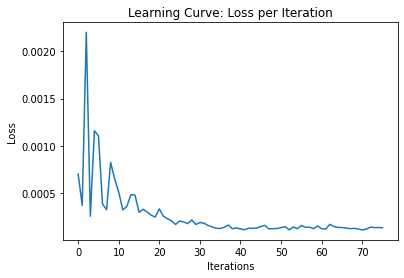

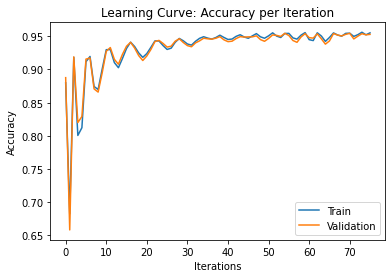

In [16]:
train_data_new = train_data_feature
valid_data_new = valid_data_feature
test_data_new = test_data_feature

mlp = MLP()
learning_curve_info = train(mlp,
                            train_data_new,
                            valid_data_new,
                            weight_decay=0.1,
                            optimizer="adam",
                            learning_rate=0.001,
                            num_epochs=4,
                            checkpoint_path='/Users/bing/Desktop/413_a3/CSC413-final-project/mlp/ckpt-{}.pk')
plot_learning_curve(*learning_curve_info)

tensor([1])


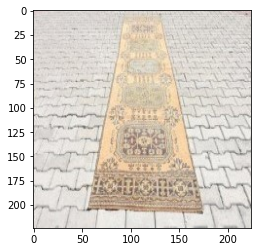

In [17]:
# Correctly classify
for image, label in test_loader:
    feature = alexnet.features(image).detach()
    mlp.eval()
    output = mlp(feature)
    pred = int(output.max(1, keepdim=True)[1][0][0])
    if pred == label:
        print(label)
        image = image.squeeze(0)
        image = torch.permute(image, (1,2,0))
        plt.figure()
        plt.imshow(image)
        break

tensor([0])


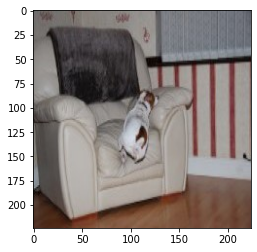

In [19]:
# Incorrectly classify
for image, label in test_loader:
    feature = alexnet.features(image).detach()
    mlp.eval()
    output = mlp(feature)
    pred = int(output.max(1, keepdim=True)[1][0][0])
    if pred != label:
        print(label)
        image = image.squeeze(0)
        image = torch.permute(image, (1,2,0))
        plt.figure()
        plt.imshow(image)
        break